In [55]:
# 设置数据集名称
dataset_name = ['LUAD']
# 设置俩： ['LUAD', 'LUSC']
# 单一个： ['LUAD'] 
method = 'normal' # diff是上面俩数据集的差异，normal是和正常样本的差异
# method = 'diff'

In [56]:
import requests
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from typing import Tuple, List
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
from multiprocessing import Pool, cpu_count
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet,ElasticNetCV,SGDClassifier,RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC
warnings.filterwarnings('ignore')

In [57]:
def download_and_parse_data(dataset_name):
    pkl_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna_transposed.pkl'
    if os.path.exists(pkl_file_path):
        df_t = pd.read_pickle(pkl_file_path)
    else:
        url = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-" + dataset_name + ".mirna.tsv.gz"
        response = requests.get(url)
        os.makedirs('./datasets', exist_ok=True)
        gz_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv.gz'
        with open(gz_file_path, 'wb') as f_out:
            f_out.write(response.content)
        tsv_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv'
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(tsv_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        df = pd.read_csv(tsv_file_path, sep='\t')
        df_t = df.transpose()
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop(df_t.index[0])
        df_t = np.power(2, df_t) - 1
        df_t = df_t.round(4)
        df_t['Status'] = df_t.index.map(lambda x: 1 if x.split('-')[3][:2] == '01' else 0)
        df_t = df_t[['Status'] + [col for col in df_t.columns if col != 'Status']]
        df_t.to_pickle(pkl_file_path)
        os.remove(gz_file_path)
        os.remove(tsv_file_path)
    df_t = df_t.apply(pd.to_numeric)
    return df_t

def find_healthy_samples(df):
    healthy_samples_df = df[df['Status'] == 0]
    return healthy_samples_df

if method == "diff":
    dataA = download_and_parse_data(dataset_name[0])
    dataB = download_and_parse_data(dataset_name[1])

    A_up = dataA[dataA['Status'] == 1]
    B_up = dataB[dataB['Status'] == 1]

    B_up['Status'] = 0
    df_transposed = pd.concat([A_up, B_up], ignore_index=True)
elif method == "normal":
    df_transposed = pd.DataFrame()
    for name in dataset_name:
        df_transposed = df_transposed.append(download_and_parse_data(name))
train_data = df_transposed.apply(pd.to_numeric)
# # split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['Status'], axis=1), train_data['Status'], test_size=0.2, random_state=42)
# # combine test data
train_data = pd.concat([X_test, y_test], axis=1)

In [58]:
# 选择的模型
# 实际输入的模型
feature = ['hsa-mir-182', 'hsa-mir-21', 'hsa-mir-148a', 'hsa-mir-375', 'hsa-let-7b', 'hsa-mir-143']
weight = [25.0, 15.0, 25.0, 10.0, 3.0, -3.0] 
threshold = 0.0

feature: ['hsa-mir-182', 'hsa-mir-21', 'hsa-mir-148a', 'hsa-mir-375', 'hsa-let-7b', 'hsa-mir-143']
weight: [25.0, 15.0, 25.0, 10.0, 3.0, -3.0]


# 画每个的数据

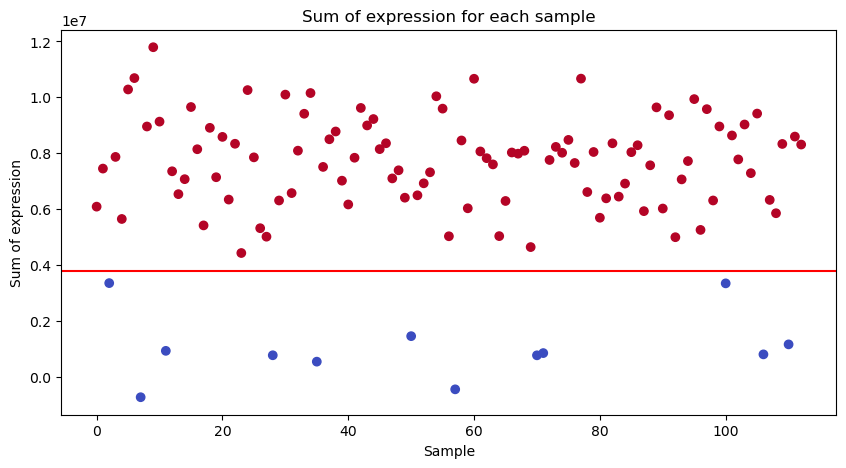

In [60]:
# 仅选择特征和最终结果. 输出末2行
ID = feature.copy()
ID = np.array(ID).reshape(-1)
# 加('Status')
ID = np.append(ID, ['Status'])
ID.astype('str')
testdata = train_data[ID]
# 把testdata的columns的名字改成feature
testdata.columns = feature + ["target"]
testdata.tail(2)
# 计算每一种基因在不同感染情况下的表达量的平均值
# weight 的最后一位是target，不需要计算，设置为1
weight = np.array(weight).reshape(-1)
weight = np.append(weight, [1])
testdata_mean = testdata  * weight
weight = weight.reshape(-1)
weight = weight[:-1]
#testdata_mean
# 计算每一行的和，要去掉最后一列
testdata_mean['sum'] = (testdata_mean.sum(axis=1) - testdata_mean['target']) 
# 画分布图
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(range(len(testdata_mean)), testdata_mean['sum'], c=testdata_mean['target'], cmap='coolwarm')
ax.set_xlabel('Sample')
ax.set_ylabel('Sum of expression')
ax.set_title('Sum of expression for each sample')

# threshold 画线
ax.axhline(y=threshold, color='r', linestyle='-')

## 画分布图


In [61]:
mean = train_data.groupby("Status").mean()

# mean only keep which in feature
mean = mean[feature]

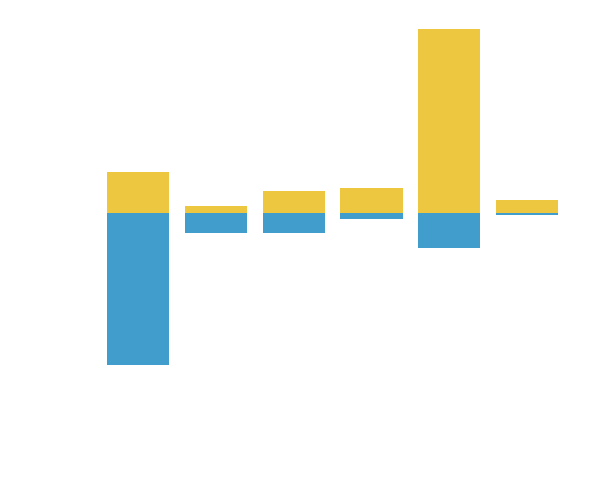

In [62]:
times = mean.iloc[0] / mean.iloc[1]
times = pd.concat([times, mean.T], axis=1)
times.columns = ['times', '0', '1']
# if 0 and 1 are both 0, then remove the row
times = times[times['times'] > 0]
# and not infinity
times = times[times['times'] < 100000]
times = times[times['0'] > 1]
times = times[times['1'] > 1]
# sort by times
times = times.sort_values(by=['times'], ascending=False)
times = pd.concat([times.head(30), times.tail(30)])
fig, ax = plt.subplots()
ax.bar(times.index, times['1'], color='#eec740')
ax.bar(times.index, -times['0'], color='#419dcc')
# background color
# ax.set_facecolor('#142235')
# 外部透明
fig.patch.set_alpha(0)
# 标注字体颜色白色
ax.tick_params(colors='white')
# 内部透明
ax.patch.set_alpha(0)
# 线框颜色 白色
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')

# log scale
# ax.set_yscale('symlog')
# 文字方向
plt.xticks(rotation=90)
# 导出图片为svg
fig.savefig('./output/' + '-'.join(dataset_name) + '.svg', transparent=True)
# show image
plt.show()